<a href="https://colab.research.google.com/github/pepetonof/NASGP-Net/blob/main/Tutorial_NASGPNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install deap
!pip install torchinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.3 MB/s eta 0:00:00


#Clone NASGP-Net Repository

In [ ]:
!git clone https://github.com/pepetonof/NASGP-Net.git
%cd NASGP-Net

Cloning into 'NASGP-Net'...
remote: Enumerating objects: 441, done.
remote: Total 441 (delta 0), reused 0 (delta 0), pack-reused 441
Receiving objects: 100% (441/441), 47.94 MiB | 10.56 MiB/s, done.
Resolving deltas: 100% (108/108), done.
/content/NASGP-Net


#Cell-based codification used by NASGP-Net

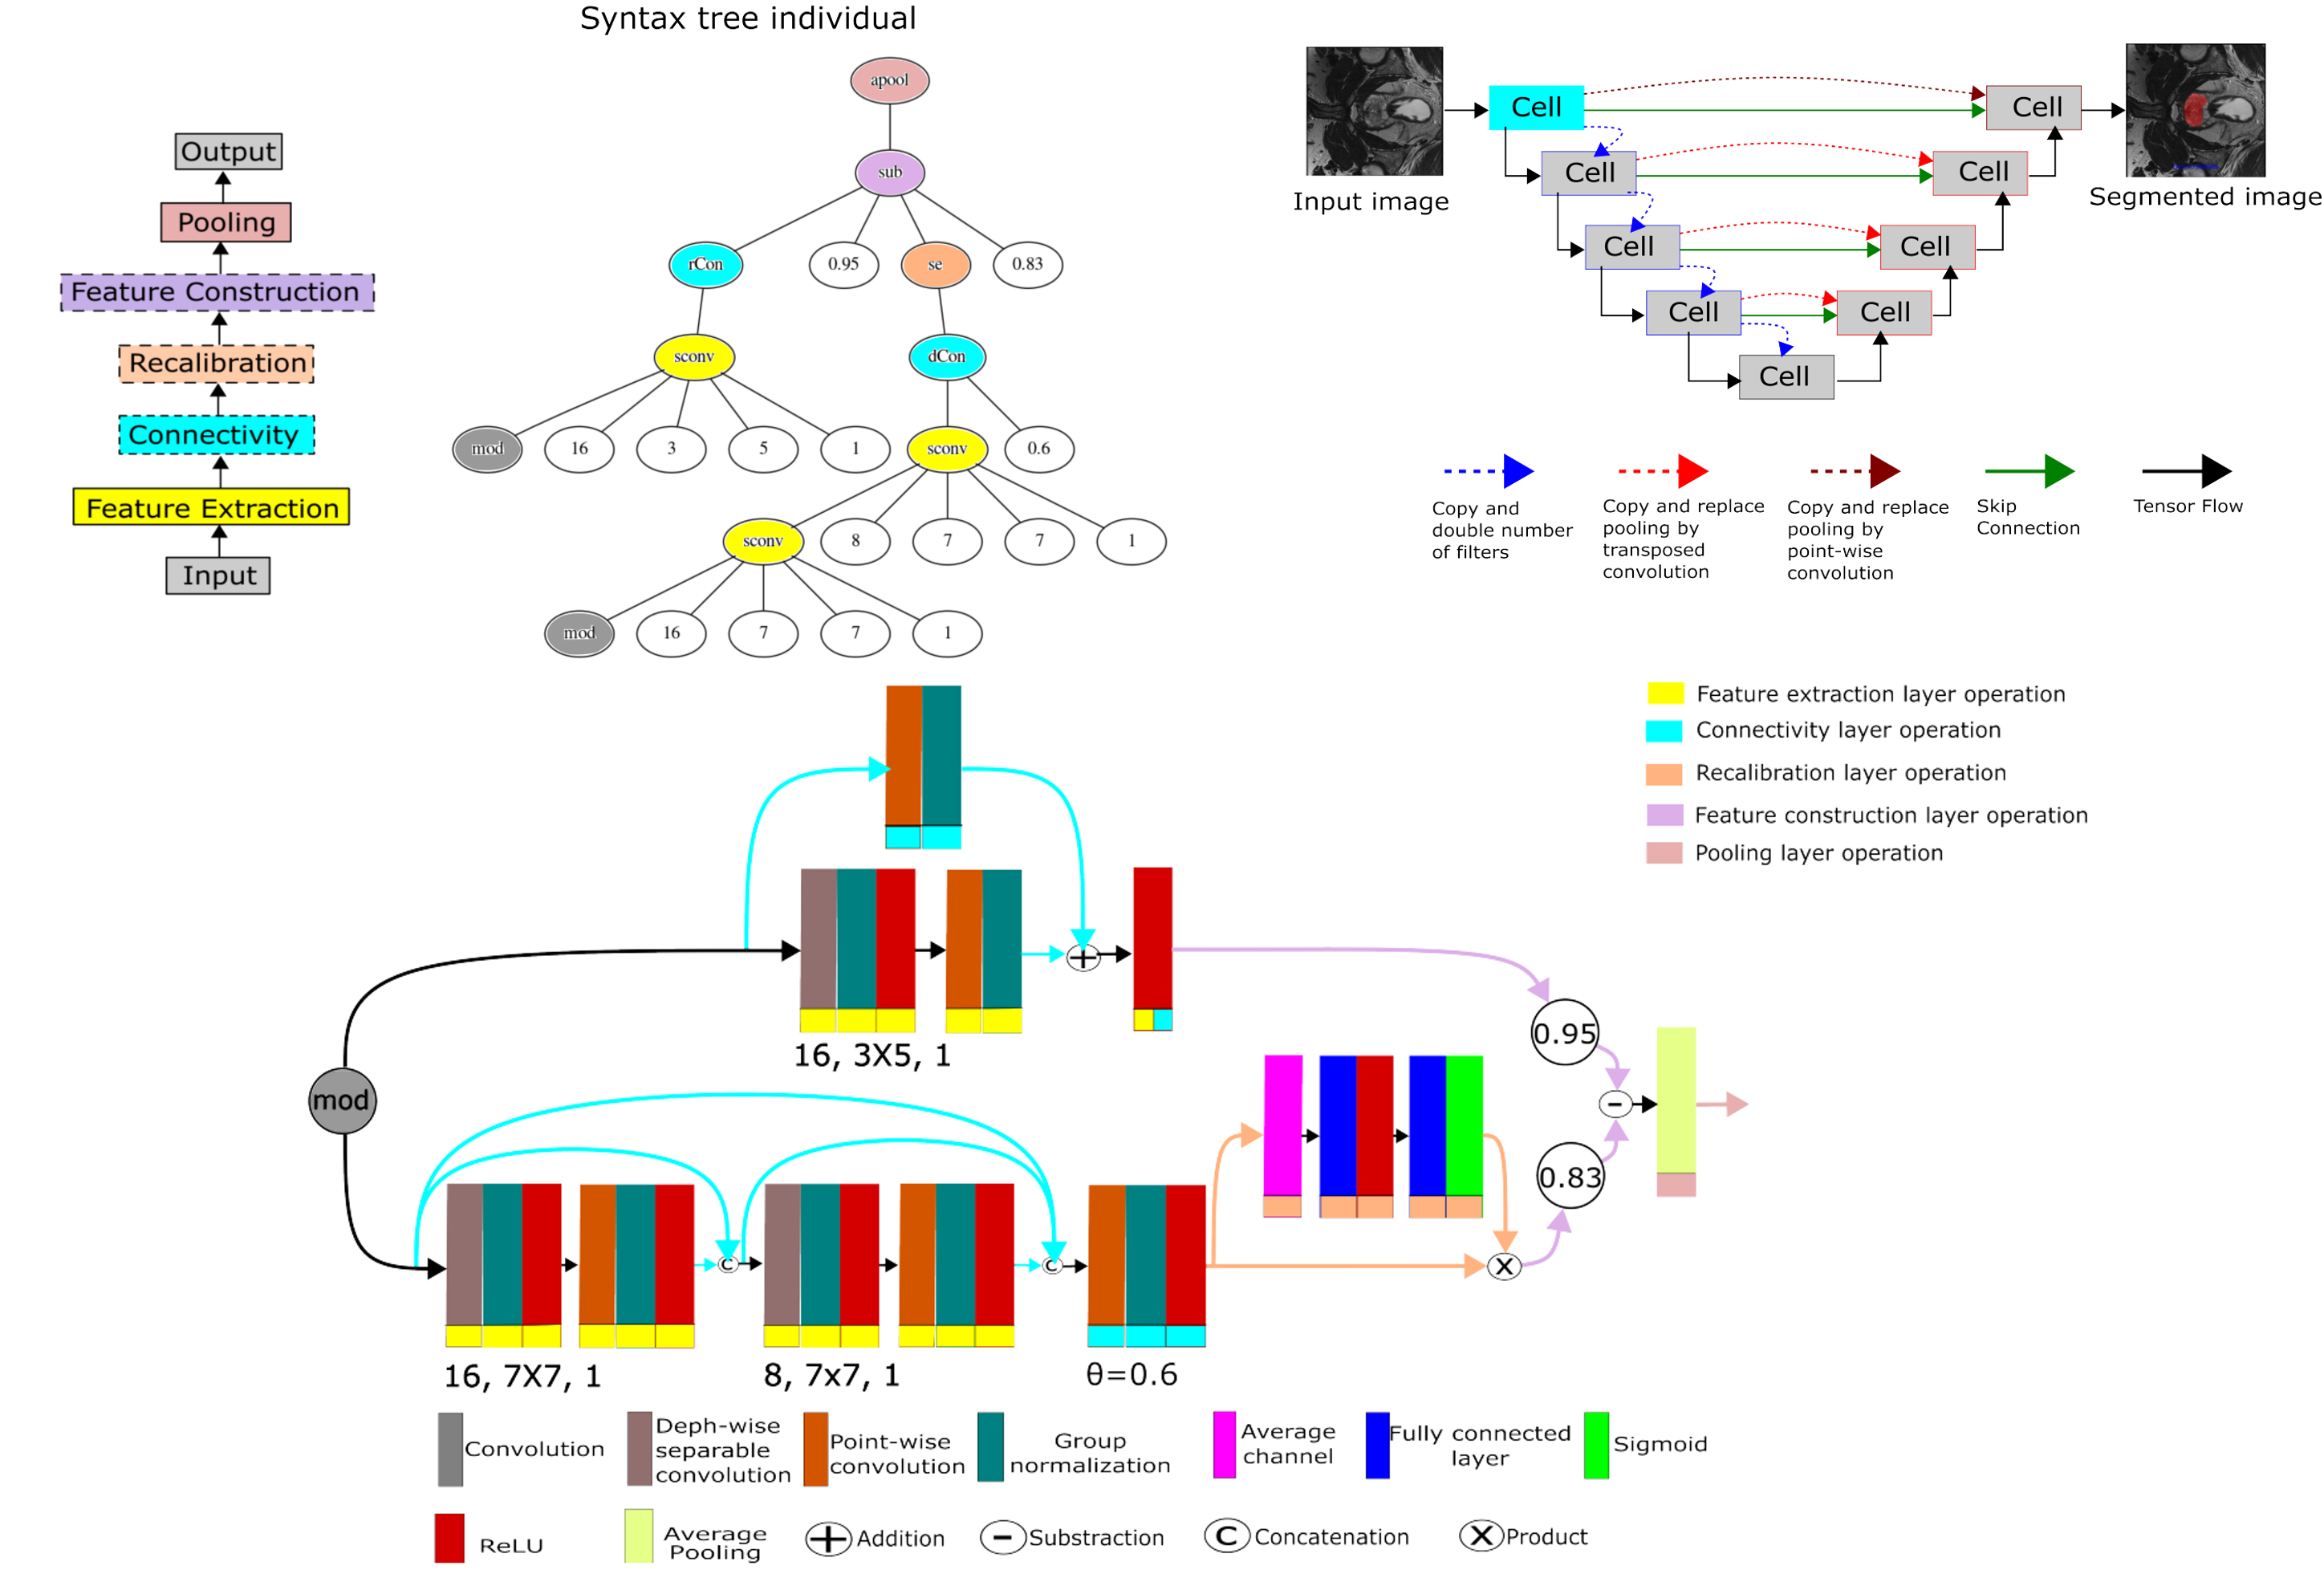

##Primitive Set

#### Terminal Set


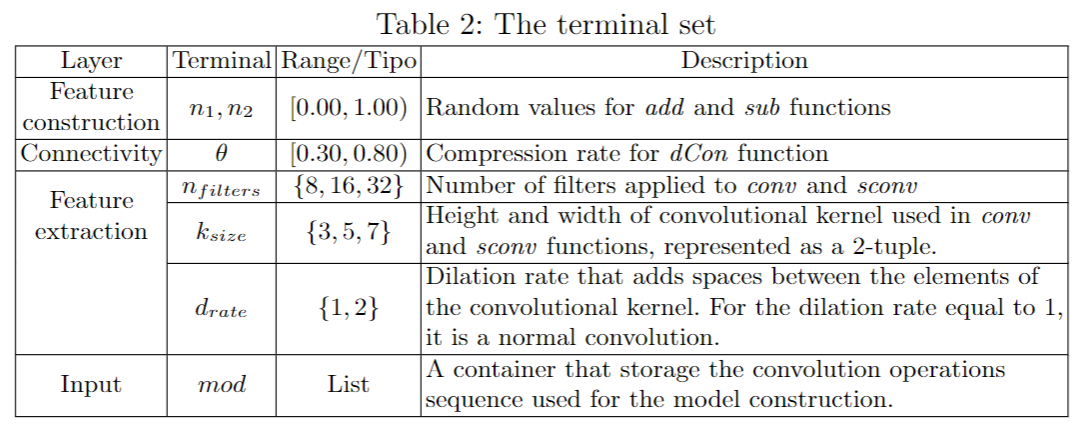

### Function Set

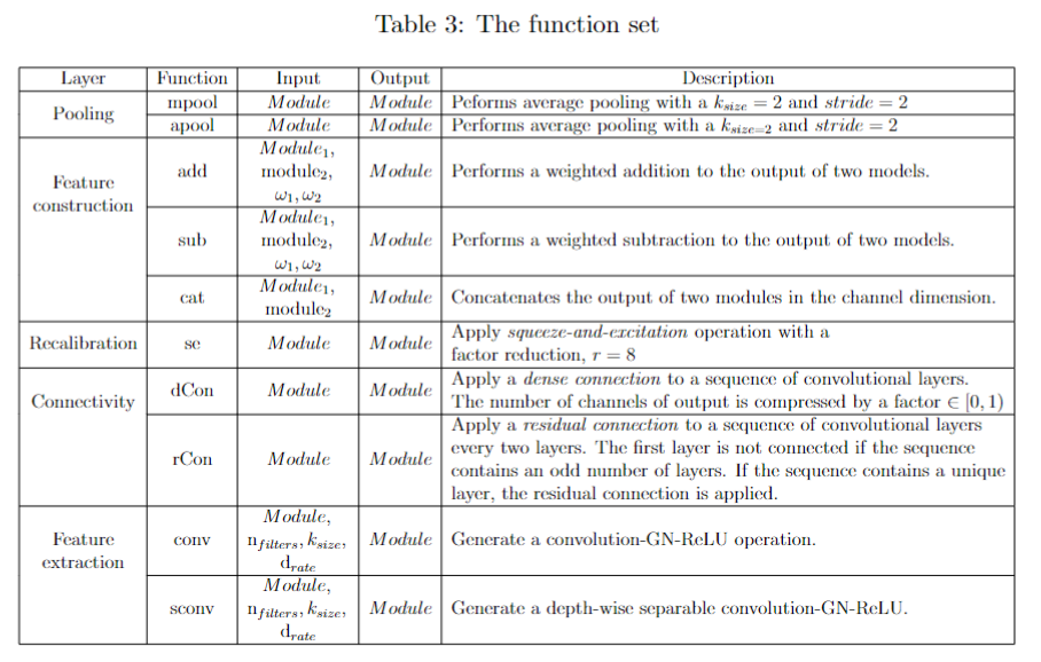

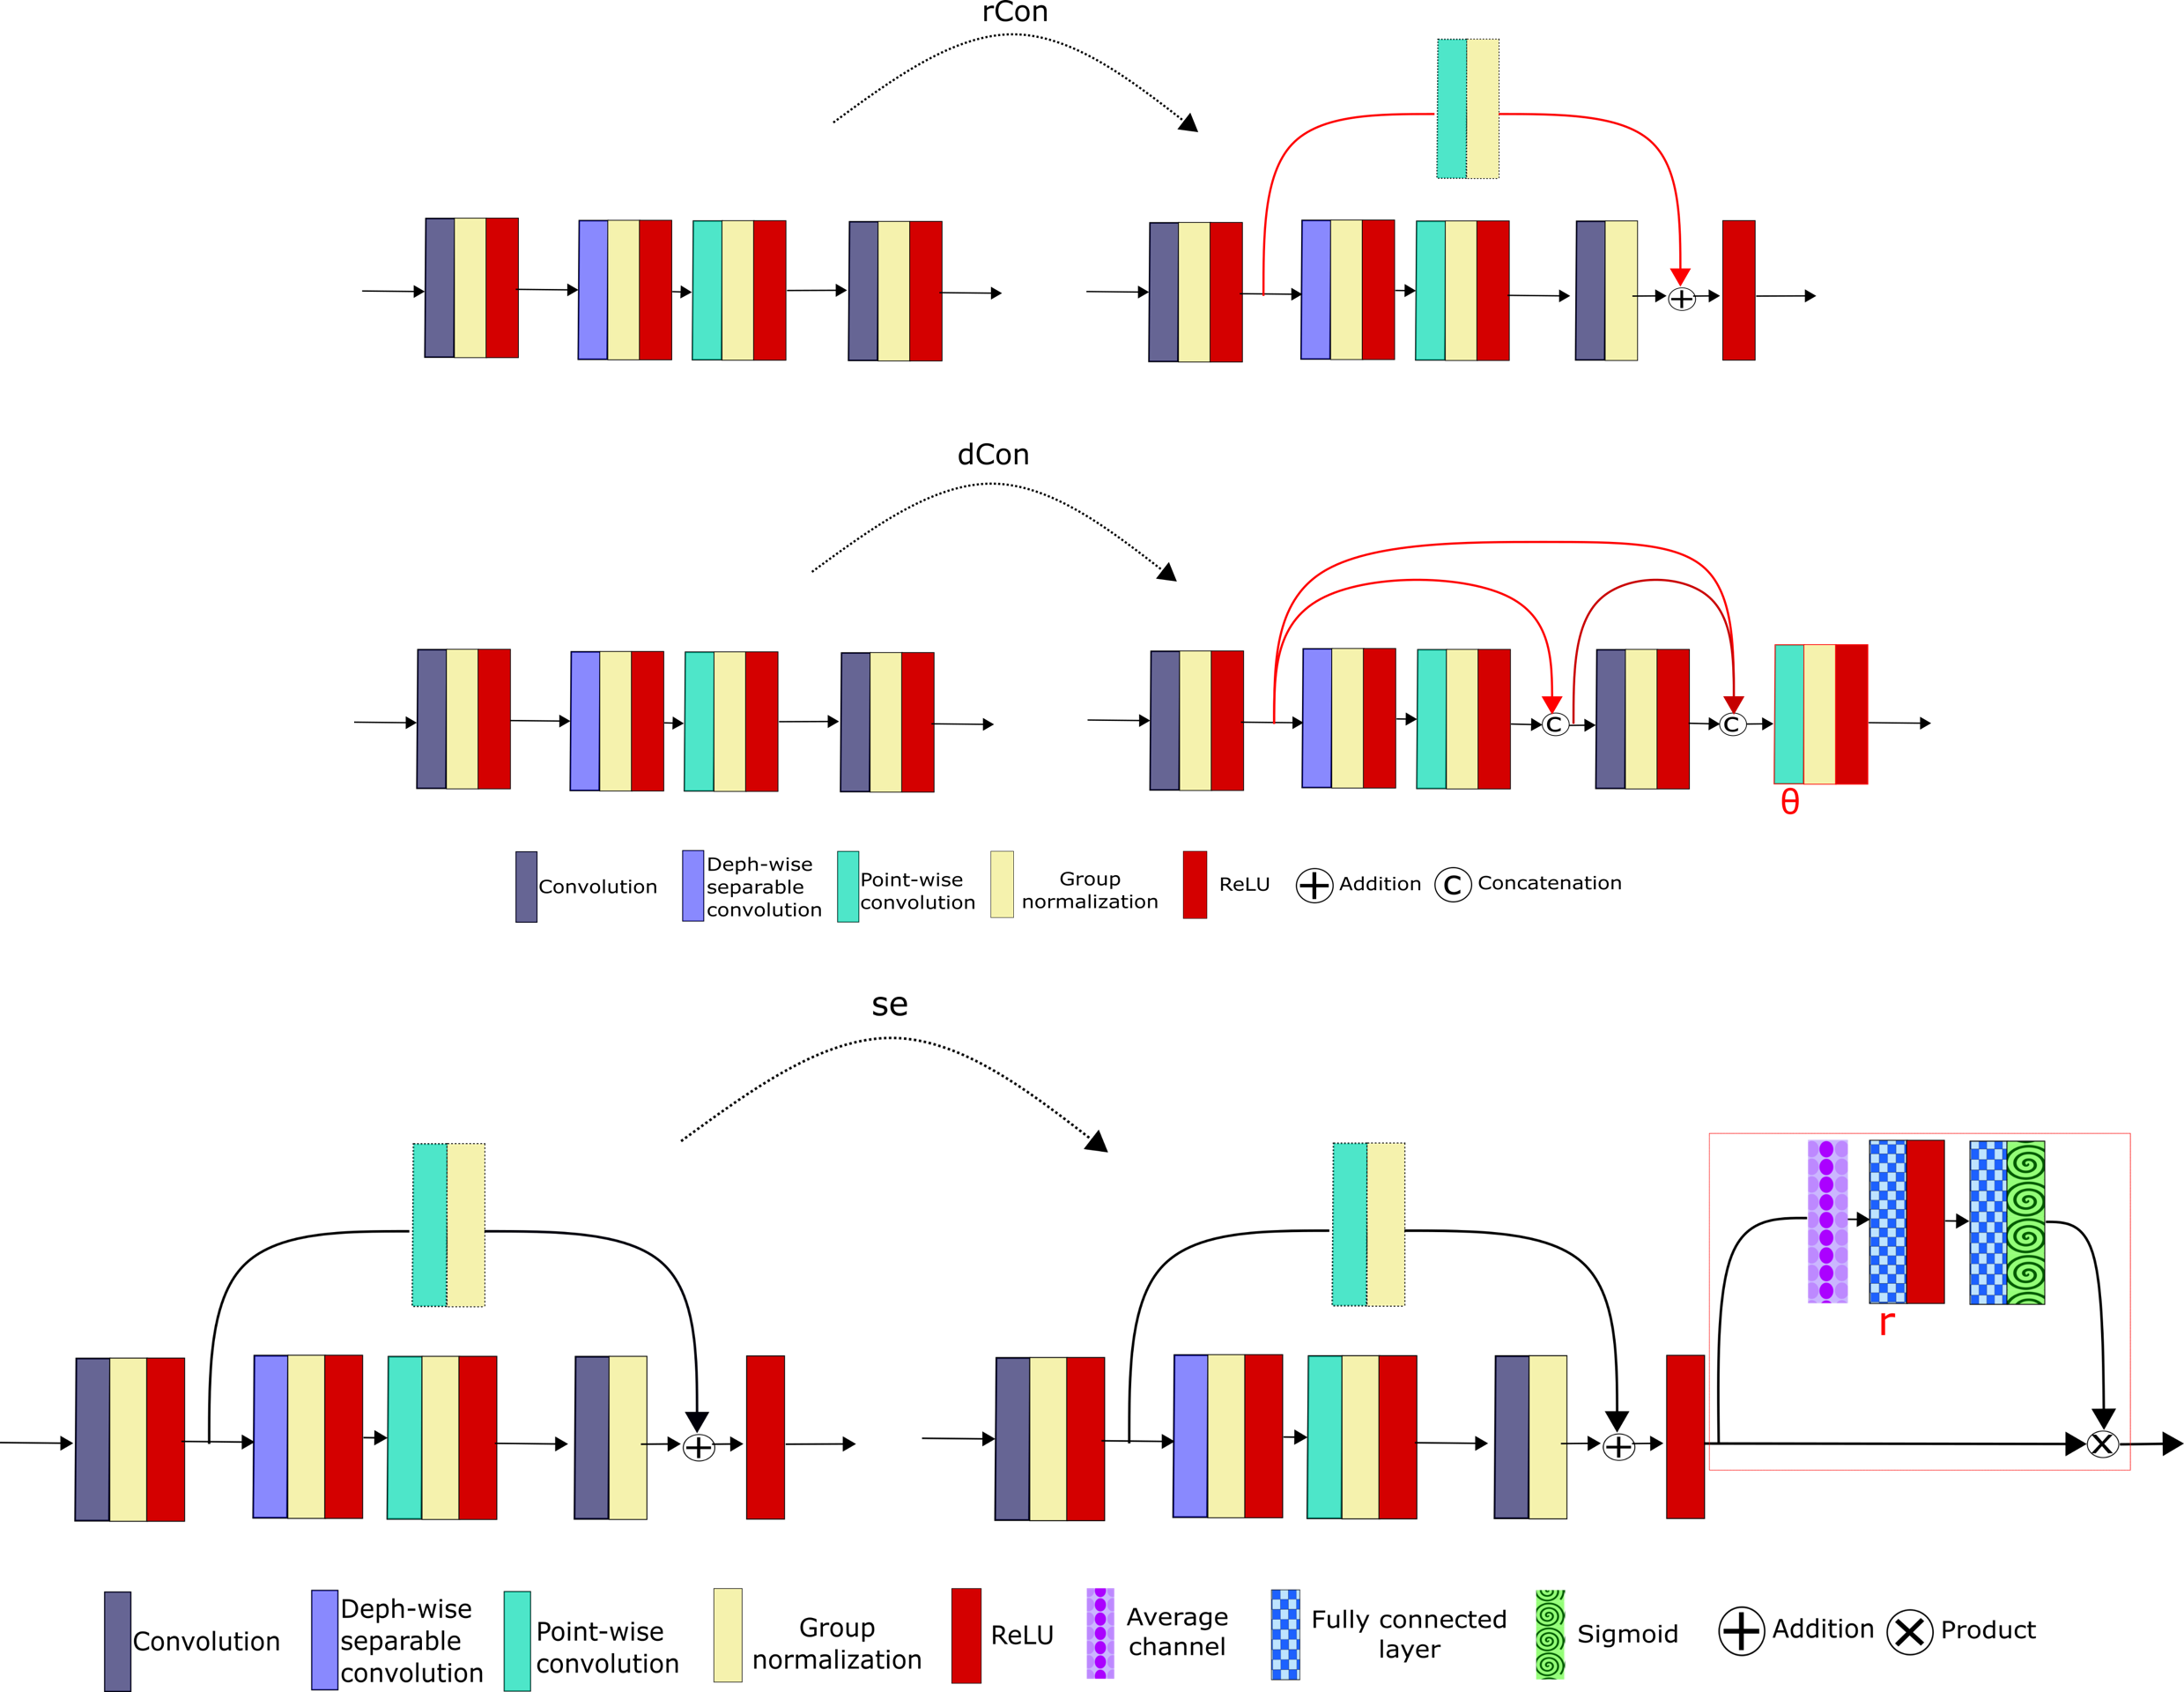

##DEAP

In [ ]:
import gp_restrict, gp_tree, operator
from deap import creator, base, tools, gp
import os
#from repository
from strongGPDataType import (moduleTorch, moduleTorchL, moduleTorchSe, moduleTorchCn, moduleTorchCt, moduleTorchP,
                              outChConv, outChSConv, kernelSizeConv, dilationRate,
                              tetha,wArithm)
from operators.functionSet import (convolution, sep_convolution,
                                  res_connection, dense_connection,
                                  se,
                                  add, sub, cat,
                                  maxpool, avgpool)
from toolbox_functions import (make_model, save_ind, identifier, save_graphtv, save_graphtvd) #evaluation
from losses.loss_functions import DiceLoss
from metrics.segmentation_metrics import DiceMetric, IoUMetric
import numpy as np

In [ ]:
#Primitive Set Using Strongly Typed GP to get a Multi-tier Structure
pset = gp_tree.PrimitiveSetTyped("main", [moduleTorch], moduleTorchP)

#Pooling Layer
pset.addPrimitive(maxpool, [moduleTorchL],
                  moduleTorchP, name='mpool')
pset.addPrimitive(avgpool, [moduleTorchL],
                  moduleTorchP, name='apool')

pset.addPrimitive(maxpool, [moduleTorchCn],
                  moduleTorchP, name='mpool')
pset.addPrimitive(avgpool, [moduleTorchCn],
                  moduleTorchP, name='apool')

pset.addPrimitive(maxpool, [moduleTorchSe],
                  moduleTorchP, name='mpool')
pset.addPrimitive(avgpool, [moduleTorchSe],
                  moduleTorchP, name='apool')

pset.addPrimitive(maxpool, [moduleTorchCt],
                  moduleTorchP, name='mpool')
pset.addPrimitive(avgpool, [moduleTorchCt],
                  moduleTorchP, name='apool')


#Feature Construction Layer Optional
#L,L; L,Cn; Cn,L; Cn,Cn;
pset.addPrimitive(add, [moduleTorchL, wArithm, moduleTorchL, wArithm],
                  moduleTorchCt, name='add')
pset.addPrimitive(sub, [moduleTorchL, wArithm, moduleTorchL, wArithm],
                  moduleTorchCt, name='sub')
pset.addPrimitive(cat, [moduleTorchL, moduleTorchL],
                  moduleTorchCt, name='cat')

pset.addPrimitive(add, [moduleTorchL, wArithm, moduleTorchCn,  wArithm],
                  moduleTorchCt, name='add')
pset.addPrimitive(sub, [moduleTorchL, wArithm, moduleTorchCn,  wArithm],
                  moduleTorchCt, name='sub')
pset.addPrimitive(cat, [moduleTorchL, moduleTorchCn],
                  moduleTorchCt, name='cat')

pset.addPrimitive(add, [moduleTorchCn, wArithm, moduleTorchL,  wArithm],
                  moduleTorchCt, name='add')
pset.addPrimitive(sub, [moduleTorchCn, wArithm, moduleTorchL,  wArithm],
                  moduleTorchCt, name='sub')
pset.addPrimitive(cat, [moduleTorchCn, moduleTorchL],
                  moduleTorchCt, name='cat')

pset.addPrimitive(add, [moduleTorchCn, wArithm, moduleTorchCn, wArithm],
                  moduleTorchCt, name='add')
pset.addPrimitive(sub, [moduleTorchCn, wArithm, moduleTorchCn, wArithm],
                  moduleTorchCt, name='sub')
pset.addPrimitive(cat, [moduleTorchCn, moduleTorchCn],
                  moduleTorchCt, name='cat')

# Se,Se; Se,L; L,Se;
pset.addPrimitive(add, [moduleTorchSe, wArithm, moduleTorchSe, wArithm],
                  moduleTorchCt, name='add')
pset.addPrimitive(sub, [moduleTorchSe, wArithm, moduleTorchSe, wArithm],
                  moduleTorchCt, name='sub')
pset.addPrimitive(cat, [moduleTorchSe, moduleTorchSe],
                  moduleTorchCt, name='cat')

pset.addPrimitive(add, [moduleTorchSe, wArithm, moduleTorchL,  wArithm],
                  moduleTorchCt, name='add')
pset.addPrimitive(sub, [moduleTorchSe, wArithm, moduleTorchL,  wArithm],
                  moduleTorchCt, name='sub')
pset.addPrimitive(cat, [moduleTorchSe, moduleTorchL],
                  moduleTorchCt, name='cat')

pset.addPrimitive(add, [moduleTorchL, wArithm, moduleTorchSe,  wArithm],
                  moduleTorchCt, name='add')
pset.addPrimitive(sub, [moduleTorchL, wArithm, moduleTorchSe,  wArithm],
                  moduleTorchCt, name='sub')
pset.addPrimitive(cat, [moduleTorchL, moduleTorchSe],
                  moduleTorchCt, name='cat')

#Cn,Se; Se,Cn;
pset.addPrimitive(add, [moduleTorchCn, wArithm, moduleTorchSe, wArithm],
                  moduleTorchCt, name='add')
pset.addPrimitive(sub, [moduleTorchCn, wArithm, moduleTorchSe, wArithm],
                  moduleTorchCt, name='sub')
pset.addPrimitive(cat, [moduleTorchCn, moduleTorchSe],
                  moduleTorchCt, name='cat')

pset.addPrimitive(add, [moduleTorchSe, wArithm, moduleTorchCn,  wArithm],
                  moduleTorchCt, name='add')
pset.addPrimitive(sub, [moduleTorchSe, wArithm, moduleTorchCn,  wArithm],
                  moduleTorchCt, name='sub')
pset.addPrimitive(cat, [moduleTorchSe, moduleTorchCn],
                  moduleTorchCt, name='cat')

# Recalibarion Layer Optional: Squeeze and Excitation Operation
pset.addPrimitive(se, [moduleTorchL],
                  moduleTorchSe, name='se')
pset.addPrimitive(se, [moduleTorchCn],
                  moduleTorchSe, name='se')

#Feature Connection Layer Optional
pset.addPrimitive(dense_connection, [moduleTorchL, tetha],#, kernelSizeConv, kernelSizeConv
                  moduleTorchCn, name='dCon')
pset.addPrimitive(res_connection, [moduleTorchL],
                  moduleTorchCn, name='rCon')

#Feature Extraction Layer
pset.addPrimitive(convolution, [moduleTorch, outChConv, kernelSizeConv, kernelSizeConv, dilationRate],
                  moduleTorch, name='conv')
pset.addPrimitive(sep_convolution, [moduleTorch, outChSConv, kernelSizeConv, kernelSizeConv, dilationRate],
                  moduleTorch, name='sconv')

pset.addPrimitive(convolution, [moduleTorch, outChConv, kernelSizeConv, kernelSizeConv, dilationRate],
                  moduleTorchL, name='conv')
pset.addPrimitive(sep_convolution, [moduleTorch, outChSConv, kernelSizeConv, kernelSizeConv, dilationRate],
                  moduleTorchL, name='sconv')

#Terminals
pset.addEphemeralConstant('outChConv', lambda:outChConv() , outChConv)
pset.addEphemeralConstant('outChSConv', lambda:outChSConv() , outChSConv)
pset.addEphemeralConstant('ksConv', lambda:kernelSizeConv() , kernelSizeConv)
pset.addEphemeralConstant('dilationR', lambda:dilationRate() , dilationRate)
pset.addEphemeralConstant('tetha', lambda:tetha(), tetha)
pset.addEphemeralConstant('w', lambda:wArithm() , wArithm)

pset.renameArguments(ARG0="mod")

#%%Creator
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax,
                dice=float, iou=float, hd=float, hd95=float,
                params=int)

#%%Toolbox
toolbox = base.Toolbox()
toolbox.register("expr", gp_restrict.genHalfAndHalfMD, pset=pset, min_=2, max_=6)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

toolbox.register('make_model', make_model, pset=pset)

# toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("selectElitism", tools.selBest)

toolbox.register("mate", gp.cxOnePointLeafBiased, termpb=0.1)

toolbox.register("expr_mut", gp_restrict.genFull, min_=0, max_=6)
toolbox.register("mutate_uniform", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.register("mutate_eph", gp.mutEphemeral, mode='all')
toolbox.register("mutate_shrink", gp.mutShrink)
toolbox.register("mutate_replace", gp.mutNodeReplacement, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=10))
toolbox.decorate("mutate_eph", gp.staticLimit(key=operator.attrgetter("height"), max_value=10))
toolbox.decorate("mutate_shrink", gp.staticLimit(key=operator.attrgetter("height"), max_value=10))
toolbox.decorate("mutate_replace", gp.staticLimit(key=operator.attrgetter("height"), max_value=10))
toolbox.decorate("mutate_uniform", gp.staticLimit(key=operator.attrgetter("height"), max_value=10))

toolbox.register("save_ind", save_ind)
# toolbox.register("plt_ind", plt_ind)

toolbox.register("save_graphtvd", save_graphtvd)
toolbox.register("save_graphtv", save_graphtv)

toolbox.register("identifier", identifier, length=10)

## Get the COVID database

In [ ]:
from data.dataset import Dataset2D
import data.dataSplit as dataSplit

#Storage folder
ruta = os.path.join("/content/", "ejecucion")
if not os.path.exists(ruta):
  os.makedirs(ruta)

#COVID dataset
path_images = "/content/NASGP-Net/images_COVID/"
in_channels = 1
out_channels = 2
dataset_type = Dataset2D
no_classes_msk = 2
image_height = 128
image_width = 128
batch_size = 8

#Split dataset
train_set, valid_set, test_set = dataSplit.get_data(0.7, 0.15, 0.15, path_images, _format=".png")

### Evolutionary parameters

In [ ]:
#Evolutionary parameters
from utils.deap_utils import log2csv, show_statics

##Statics
def statics_():
    stats_fit = tools.Statistics(lambda individual: individual.fitness.values)
    stats_size = tools.Statistics(len)
    stats_depth = tools.Statistics(lambda individual: individual.height)
    stats_dice = tools.Statistics(lambda individual: individual.dice)
    stats_iou = tools.Statistics(lambda individual: individual.iou)
    stats_params = tools.Statistics(lambda individual: individual.params)

    mstats = tools.MultiStatistics(Fitness=stats_fit,
                                   Dice=stats_dice,
                                   IoU=stats_iou,
                                   Params=stats_params,
                                   Size=stats_size,
                                   Depth=stats_depth,)

    mstats.register("mean", np.mean)
    mstats.register("median", np.median)
    mstats.register("std", np.std)
    mstats.register("min", np.min)
    mstats.register("max", np.max)

    return mstats

pz = 15
ng = 5
cxpb = 0.5
mutpb = 0.49
nelit = 1
tz = 3
mstats = statics_()
hof = tools.HallOfFame(nelit)
checkpoint_name = False#'checkpoint_evo.pkl'
verbose_evo = False
max_params = 31038000
w = 0.01
k_folds = False

toolbox.register("select", tools.selTournament, tournsize=tz)

### Fitnesss Function

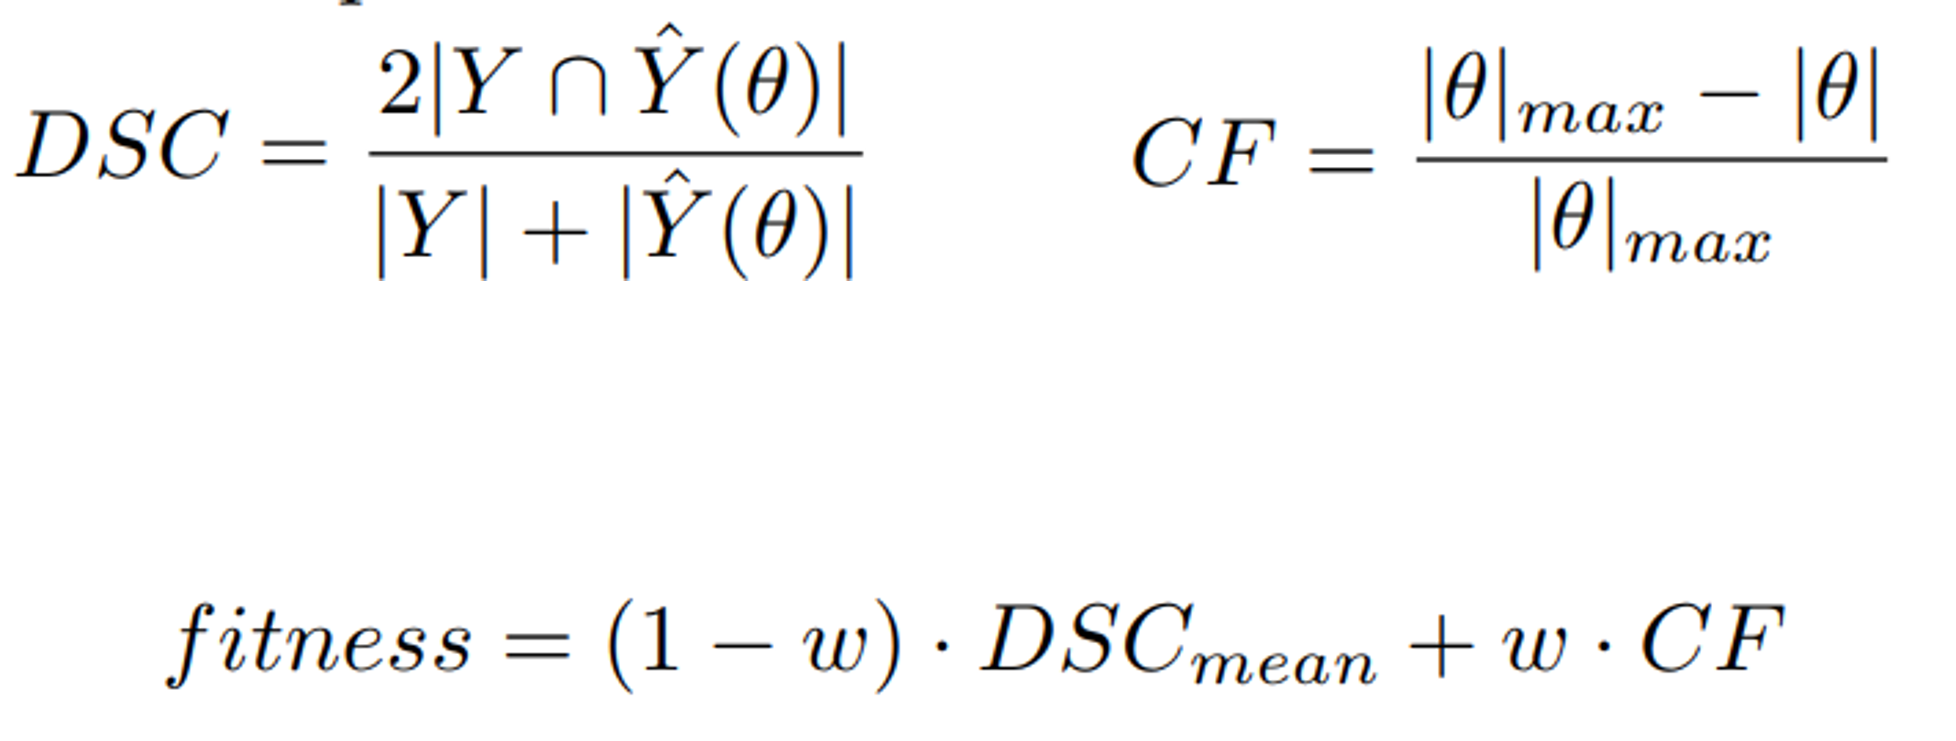




In [ ]:
from objective_functions import evaluate_NoParameters, evaluate_Segmentation
from data.dataloader import loaders
from torchinfo import summary
from model.model import BackBone
import numpy as np
import torch.nn as nn
import pickle

#Training_parameters
nepochs = 10
lossfn = DiceLoss(average='macro', include_background=False, softmax=False, eps=1e-8)

metrics = [
    DiceMetric(average='macro', include_background=False, softmax=False, eps=1e-8),
    IoUMetric(average='macro', include_background=False, softmax=False, eps=1e-8),
    ]
lr = 0.0001
tolerance = 0 #for early stopping
verbose_train=False
device='cuda:0'
save_model=False
save_images=False
save_data=False

def make_model(ind, in_channels, out_channels, pset):
  """Compile function"""
  func = gp.compile(expr=ind, pset=pset)
  """Init module: empty sequential module"""
  init_module=[nn.ModuleList(), in_channels]
  """Output of the first block"""
  first_block=func(init_module)
  model=BackBone(first_block, out_channels)
  return model

def evaluation(ind,
              nepochs,
              tolerance,
              lossfn,
              metrics,
              lr,
              dataset_type,
              no_classes_msk,
              in_channels,
              out_channels,
              batch_size,
              image_height,
              image_width,
              max_params, w,
              train_set,
              valid_set,
              test_set,
              pset,
              device,
              ruta,
              verbose_train,
              save_model,
              save_images,
              save_data=False,
              limit=300000000):
  model = make_model(ind, in_channels, out_channels, pset)
  complexity, params = evaluate_NoParameters(model, max_params)

  if params >= limit:
    dice =0.0
    iou = 0.0
    hd = 10
    hd95 = 10*0.95
  else:
    #Dataloaders from train_set, valid_set, test_set
    dloaders = loaders(train_set, valid_set, test_set, batch_size=batch_size,
                        image_height=image_height, image_width=image_width,
                        dataset_type=dataset_type, no_classes_msk=no_classes_msk,
                        )

    #Evaluate Segmentation Metrics
    metricsTest, metricsVal, lossAndDice = evaluate_Segmentation(model, nepochs, tolerance, lossfn, metrics,
                                                                 lr, dloaders,
                                                                 device, ruta, verbose_train,
                                                                 save_model, save_images, fold=None)
    # Segmentation metrics: Mean value on the test set
    dice = np.mean(metricsTest["DiceMetric"])
    iou  = np.mean(metricsTest["IoUMetric"])

    fit = (1-w)*dice + w*complexity

    if save_data:
      path_data = f"{ruta}/data/"
      if not os.path.exists(path_data):
          os.makedirs(path_data)
      with open(f"{path_data}/metricsTest.pkl", "wb") as cp_file:
          pickle.dump(metricsTest, cp_file)
      with open(f"{path_data}/metricsVal.pkl", "wb") as cp_file:
          pickle.dump(metricsVal, cp_file)
      with open(f"{path_data}/lossAndDice.pkl", "wb") as cp_file:
          pickle.dump(lossAndDice, cp_file)
      d={}
      d_aux = {"Height": dloaders.IMAGE_HEIGHT,
                "Width":dloaders.IMAGE_WIDTH,
                "Train_Size":len(dloaders.TRAIN_IMG_DIR),
                "Valid_Size":len(dloaders.VAL_IMG_DIR),
                "Test_Size": len(dloaders.TEST_IMG_DIR),}
      d.update(d_aux)
      d_aux = {"Ind":ind, "Ind_Fitness":ind.fitness.values[0],

              "DiceMean": dice, "DiceMedian":np.median(metricsTest["DiceMetric"]), "DiceMax":np.max(metricsTest["DiceMetric"]),
              "DiceMin": np.min(metricsTest["DiceMetric"]), "DiceStd":np.std(metricsTest["DiceMetric"]),

              "IoUMean": iou, "IoUMedian":np.median(metricsTest["IoUMetric"]), "IoUMax": np.max(metricsTest["IoUMetric"]),
              "IoUMin": np.min(metricsTest["IoUMetric"]), "IoUStd": np.std(metricsTest["IoUMetric"]),
              }
      d.update(d_aux)
      model_stats=summary(model, (batch_size, in_channels, image_height, image_width), verbose=0)
      summary_model = str(model_stats)
      d_aux = {"Summary_Model": summary_model}
      d.update(d_aux)

      with open(f"{path_data}/data.txt", 'w', encoding="utf-8") as f:
          for key, value in d.items():
              f.write('%s\n%s\n' % (key, value))

      #Save the train_set, valid_set and test_set in a .txt files
      with open(f"{path_data}/train_set.txt", 'w', encoding="utf-8") as f:
          for key, value in train_set.items():
              f.write('%s\n' % (key))
              for name in [path.name for path in value]:
                  f.write('%s\n' % (name))

      with open(f"{path_data}/valid_set.txt", 'w', encoding="utf-8") as f:
          for key, value in valid_set.items():
              f.write('%s\n' % (key))
              for name in [path.name for path in value]:
                  f.write('%s\n' % (name))

      with open(f"{path_data}/test_set.txt", 'w', encoding="utf-8") as f:
          for key, value in test_set.items():
              f.write('%s\n' % (key))
              for name in [path.name for path in value]:
                  f.write('%s\n' % (name))

  return fit, dice, iou, params


toolbox.register("evaluate", evaluation,
                            nepochs=nepochs,
                            tolerance=tolerance,
                            lossfn=lossfn,
                            metrics=metrics,
                            lr=lr,
                            dataset_type = dataset_type,
                            no_classes_msk = no_classes_msk,
                            in_channels=in_channels,
                            out_channels=out_channels,
                            batch_size = batch_size,
                            image_height = image_height,
                            image_width = image_width,
                            max_params=max_params, w=w,
                            train_set=train_set,
                            valid_set=valid_set,
                            test_set=test_set,
                            pset = pset,
                            device=device,
                            ruta=ruta,
                            verbose_train=verbose_train,
                            save_model=save_model,
                            save_images=save_images,
                            save_data=save_data
                            )

### Evolutionary process

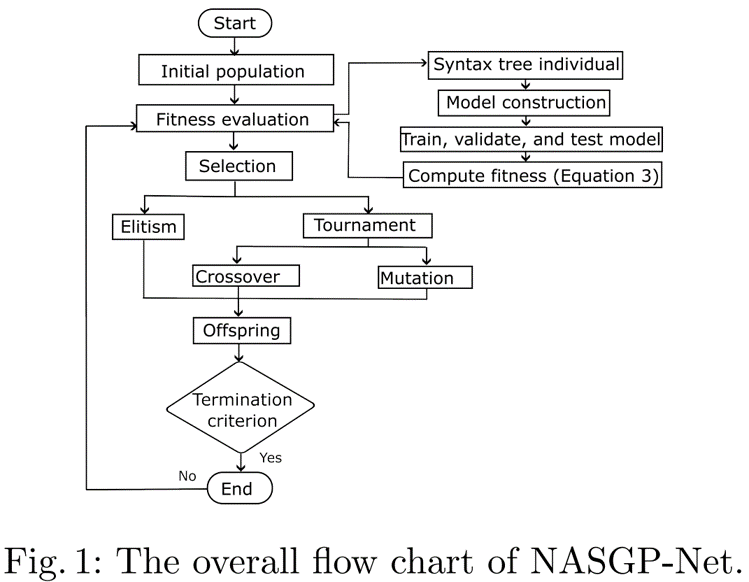

In [ ]:
from datetime import datetime, timedelta
import random

#Variation Operators
def MateMutation(population, toolbox, lambda_, cxpb, mutpb):
  assert (cxpb + mutpb) <= 1.0, (
      "The sum of the crossover and mutation probabilities must be smaller "
      "or equal to 1.0.")
  mut_options = ['shrink','replace','uniform']
  offspring = []
  for _ in range(lambda_):
      op_choice = random.random()
      if op_choice < cxpb:            # Apply crossover
          ind1, ind2 = list(map(toolbox.clone, random.sample(population, 2)))
          ind1, ind2 = toolbox.mate(ind1, ind2)
          del ind1.fitness.values
          offspring.append(ind1)
      elif op_choice < cxpb + mutpb:  # Apply mutation
          mut_op = random.choice(mut_options)
          ind = toolbox.clone(random.choice(population))
          if mut_op=='shrink':
              ind, = toolbox.mutate_shrink(ind)
          elif mut_op=='uniform':
              ind, = toolbox.mutate_uniform(ind)
          del ind.fitness.values
          offspring.append(ind)
      else:
          ind = toolbox.clone(random.choice(population))# Apply leave mutation
          ind = toolbox.mutate_eph(ind)
          del ind.fitness.values
          offspring.append(ind)
          # offspring.append(random.choice(population))

  return offspring


def eaNASGPNet(pop_size, toolbox, cxpb, mutpb, ngen, nelit,
               ruta, checkpoint_name,
               stats=None, halloffame=None, verbose_evo=__debug__,):

  init_time=datetime.now()
  delta_t=timedelta(seconds=0)

  population = toolbox.population(n=pop_size) #Initial population
  start_gen = 0
  halloffame = tools.HallOfFame(maxsize = nelit)

  logbook = tools.Logbook()
  logbook.header = ['gen', 'nevals', 'time', 'best',
                    'best_dice', 'best_iou', 'best_params'] + (stats.fields if stats else [])

  idx = 0
  no_evs = 0
  cache = {}

  invalid_ind = [ind for ind in population if not ind.fitness.valid]
  for idx in range(len(invalid_ind)): #idx<len(invalid_ind): #First evaluation
    ind = invalid_ind[idx]
    key = toolbox.identifier(ind)
    if key in cache:
      #Assign attributes from cache
      ind.fitness.values = cache[key].fitness.values
      ind.dice = cache[key].dice
      ind.iou = cache[key].iou
      ind.params = cache[key].params

      print('Syntax tree:\t', str(ind), round(ind.fitness.values[0],3), round(ind.dice,3), ind.params, "\t in cache")
    else:
      fit = toolbox.evaluate(ind)
      ind.fitness.values = fit[0],
      ind.dice = fit [1]
      ind.iou = fit[2]
      ind.params = fit[3]

      cache[key] = ind
      no_evs+=1

      print('Syntax tree:\t', str(ind), round(ind.fitness.values[0], 3), round(ind.dice, 3), ind.params, "\t in original")

    ####Take time every evaluation
    t = datetime.now()
    delta_t += (t - init_time)
    init_time = t

    print(f"{idx}/{len(invalid_ind)}", start_gen, ruta.split("/").pop(), delta_t)

  best_ind = tools.selBest(population, 1)[0]
  print('Best:', str(best_ind), round(best_ind.fitness.values[0],3), round(best_ind.dice,3),best_ind.params, start_gen)

  # Append the current generation statistics to the logbook
  record = stats.compile(population) if stats else {}
  logbook.record(gen=start_gen, nevals=no_evs, time=delta_t,
                  best = str(best_ind),
                  best_dice=best_ind.dice,
                  best_iou=best_ind.iou,
                  best_params=best_ind.params,
                  **record)

  for gen in range(1, ngen+1):
    print('\nGen:\t', gen)

    #Elitism
    population_for_eli=[toolbox.clone(ind) for ind in population]
    elitism_inds = toolbox.selectElitism(population_for_eli, k=nelit)

    #Tournament selection
    offspring = toolbox.select(population, len(population) - nelit)

    #Crossover and Mutation
    offspring = MateMutation(offspring, toolbox, len(offspring), cxpb, mutpb)

    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    idx = 0

    for idx in range(len(invalid_ind)):#< len(invalid_ind):
      #Evaluate using cache or original model
      ind = invalid_ind[idx]
      key = toolbox.identifier(ind)

      if key in cache:
        ind.fitness.values = cache[key].fitness.values
        ind.dice = cache[key].dice
        ind.iou = cache[key].iou
        ind.params = cache[key].params
        print('Syntax tree:\t', str(ind), round(ind.fitness.values[0],3), round(ind.dice,3), ind.params, "\t in cache")

      else:
        fit = toolbox.evaluate(ind)
        ind.fitness.values = fit[0],
        ind.dice = fit [1]
        ind.iou = fit[2]
        ind.params = fit[3]

        #Add to cache
        cache[key] = ind
        no_evs+=1

        print('Syntax tree:\t', str(ind), round(ind.fitness.values[0], 3), round(ind.dice,3), ind.params, "\t in original")

      ####Take time every evaluation
      t = datetime.now()
      delta_t += (t - init_time)
      init_time = t

      population = elitism_inds + offspring #update population considering elitism individuals and offspring with a new evaluated individual
      print(f"{idx}/{len(invalid_ind)}", gen, ruta.split("/").pop(), delta_t)

    # Update the hall of fame with the generated individuals
    if halloffame is not None:
      halloffame.update(offspring)

    # Take time every evaluation and every generation
    t = datetime.now()
    delta_t += (t - init_time)
    init_time = t #Keep delta_t, no matters loose t

    best_ind = tools.selBest(population, 1)[0]
    print('Best:', str(best_ind), round(best_ind.fitness.values[0],3), round(best_ind.dice,3), best_ind.params, gen)

    # Append the current generation statistics to the logbook
    record = stats.compile(population) if stats else {}
    logbook.record(gen=gen, nevals=no_evs, time=delta_t,
                    best = str(best_ind),
                    best_dice=best_ind.dice,
                    best_iou=best_ind.iou,
                    best_params=best_ind.params,
                    **record)

  print("Time", delta_t)
  return population, logbook, cache

#### Calling eaNASGPNet()

In [ ]:
import warnings
warnings.filterwarnings('ignore')

pop, log, cache = eaNASGPNet(pop_size = pz, toolbox = toolbox,
                            cxpb = cxpb, mutpb = mutpb,
                            ngen = ng, nelit = nelit,
                            ruta = ruta, checkpoint_name = checkpoint_name,
                            stats=mstats, halloffame=hof, verbose_evo=verbose_evo)

Syntax tree:	 mpool(cat(conv(conv(mod, 32, 7, 3, 1), 16, 7, 3, 1), se(conv(mod, 8, 5, 3, 1)))) 0.223 0.219 11454738 	 in original
0/5 0 ejecucion 0:00:02.975923
Syntax tree:	 mpool(sub(rCon(conv(mod, 16, 5, 7, 1)), 0.48, sconv(sconv(mod, 8, 7, 5, 2), 16, 7, 5, 2), 0.77)) 0.089 0.081 3451871 	 in original
1/5 0 ejecucion 0:00:06.016706
Syntax tree:	 mpool(se(sconv(sconv(mod, 16, 7, 7, 1), 16, 3, 5, 1))) 0.101 0.092 449957 	 in original
2/5 0 ejecucion 0:00:07.876653
Syntax tree:	 mpool(add(rCon(conv(sconv(mod, 8, 5, 5, 2), 32, 5, 3, 1)), 0.27, sconv(conv(sconv(mod, 32, 3, 3, 2), 16, 3, 7, 1), 32, 5, 7, 1), 0.6)) 0.119 0.113 8010576 	 in original
3/5 0 ejecucion 0:00:11.337235
Syntax tree:	 apool(se(sconv(conv(mod, 32, 7, 5, 1), 32, 3, 7, 1))) 0.227 0.224 13468610 	 in original
4/5 0 ejecucion 0:00:14.673427
Best: apool(se(sconv(conv(mod, 32, 7, 5, 1), 32, 3, 7, 1))) 0.227 0.224 13468610 0

Gen:	 1
Syntax tree:	 apool(se(sconv(mod, 32, 3, 7, 1))) 0.064 0.055 1190201 	 in original
0/4 1 e

In [ ]:
from utils.deap_utils import functionAnalysis
import matplotlib.pyplot as plt

##Convergence graph
def convergence_graph(logbook, ruta):
    gen=logbook.select("gen")
    fit_max=logbook.chapters["Fitness"].select("max")
    fig, host = plt.subplots()
    p1, = host.plot(gen, fit_max, "b-", label="Max Fit")
    host.set_xlabel("Generations")
    host.set_ylabel("Fitness")
    host.yaxis.label.set_color(p1.get_color())
    tkw = dict(size=4, width=1.5)
    host.tick_params(axis='y', colors=p1.get_color(), **tkw)
    lines = [p1]

    host.legend(lines, [l.get_label() for l in lines], loc="center right")

    plt.close(fig)
    plt.show()
    fig.savefig(ruta+"/Convergencia.png")

def metrics(logbook, ruta):
    gen=logbook.select("gen")
    dice=logbook.chapters["Dice"].select('mean')
    iou=logbook.chapters["IoU"].select('mean')
    hds=logbook.chapters["HD95"].select('mean')
    nsd=logbook.chapters["NSD"].select('mean')

    fig, host = plt.subplots()
    par1=host.twinx()

    p1, = host.plot(gen, dice, "b-", label="Dice")
    p2, = host.plot(gen, iou, "r-", label="IoU")

    host.set_xlabel("Generations")
    host.set_ylabel("Overlap", color="k")

    host.yaxis.label.set_color(p1.get_color())

    tkw = dict(size=4, width=1.5)
    host.tick_params(axis='y', colors=p1.get_color(), **tkw)

    lines = [p1, p2]
    host.legend(lines, [l.get_label() for l in lines], loc="lower right")

    plt.close(fig)
    plt.show()
    fig.savefig(ruta+"/Metricas.png")

#Show and save Statics as .csv
log2csv(log, mstats, ruta)
#Plot Convergence Graphs
convergence_graph(log, ruta)
#Plot metrics of populations along generations
metrics(log, ruta)
#Function Analysis
functionAnalysis(pop, 10, pset, ruta)

#Select the best individual
best = tools.selBest(pop, 1)[0]


In [ ]:
from utils.save_utils import save_execution

#Retrain the best individual
nepochs=100
verbose_train=True
save_model=True
save_images=True
save_data=True

fit = toolbox.evaluate(best,
                      nepochs=nepochs,
                      tolerance=tolerance,
                      verbose_train=verbose_train,
                      save_model=save_model,
                      save_images=save_images,
                      save_data=save_data)

best.fitness.values = fit[0],
best.dice = fit[1]
best.iou = fit[2]
best.params = fit[3]

Validation-10 		dice: 0.293431: 100%|██████████| 15/15 [00:00<00:00, 25.34it/s]


... stopped in epoch: 10


Testing 			dice: 0.321411: 100%|██████████| 15/15 [00:00<00:00, 18.06it/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r /content/ejecucion /content/drive/MyDrive/

## Conclusiones



1.   Computational Cost
2.   Flexible Representation
3.   Variation Operators



## Referencias

Fuentes-Tomás, J. A., Mezura-Montes, E., Acosta-Mesa, H. G., & Márquez-Grajales, A. (2024). Tree-Based Codification in Neural Architecture Search for Medical Image Segmentation. IEEE Transactions on Evolutionary Computation.

Vargas-Hakim, G. A., Mezura-Montes, E., & Acosta-Mesa, H. G. (2021). A review on convolutional neural network encodings for neuroevolution. IEEE Transactions on Evolutionary Computation, 26(1), 12-27.

Nirthika, R., Manivannan, S., Ramanan, A., & Wang, R. (2022). Pooling in convolutional neural networks for medical image analysis: a survey and an empirical study. Neural Computing and Applications, 34(7), 5321-5347.